In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import numpy as np
import warnings

## Obtener los datos


In [2]:
tipos_de_gastos_files_xls = [
    "data/input/gastos/alcaldia-tipos_de_gastos__alcaldia___2024-03-09T02_06_53.838153Z.xlsx",
    "data/input/gastos/gobernacion-tipos_de_gastos__2024-03-09T02_00_59.376388Z.xlsx",
]


gastos_df = pd.DataFrame()

## Concatenar los dos archivos
for f in tipos_de_gastos_files_xls:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df_temp = pd.read_excel(f, engine="openpyxl")

    gastos_df = pd.concat([gastos_df, df_temp], ignore_index=True)

## Renombrar las columnas
gastos_df = gastos_df.rename(
    columns={
        "Corporaciones - ID Corporacion → Nombre": "Cargo",
        "Formato Ingresos Gastos - ID Formato Ingresos Gasto → Codigo": "Gasto Id",
        "Candidatos → Sexo": "Sexo",
        "Candidatos → Etnia": "Etnia",
        "Departamentos - ID Departamento → Nombre": "Departamento",
        "Ciudades → Nombre": "Ciudades",
        "Agrupaciones Politicas → Nombre": "Agrupacion Politica",
        "Coalicion Politica → Nombre": "Coalicion Politica",
        "Grupos Significativos → Nombre": "Grupo Politico",
        "Suma de Gastos → Total": "Total",
    }
)


gastos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24308 entries, 0 to 24307
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Nombre               24308 non-null  object 
 1   Apellido             24308 non-null  object 
 2   Cargo                24308 non-null  object 
 3   Gasto Id             24308 non-null  int64  
 4   Sexo                 24306 non-null  object 
 5   Etnia                12321 non-null  float64
 6   Departamento         24308 non-null  object 
 7   Ciudades             23005 non-null  object 
 8   Agrupacion Politica  14245 non-null  object 
 9   Coalicion Politica   9057 non-null   object 
 10  Grupo Politico       827 non-null    object 
 11  Total                24308 non-null  float64
 12  Contar               24308 non-null  int64  
 13  Etnias               12321 non-null  object 
 14  Género               24306 non-null  object 
 15  Codigo Pro           24308 non-null 

### Convertir tres columnas con valores únicos a dos columnas con tipo y valor


In [3]:
columnas_originales = [
    "Agrupacion Politica",
    "Coalicion Politica",
    "Grupo Politico",
]


def categorizar(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]
    if isinstance(aggPolitica, str):
        return "Agrupacion Politica"
    if isinstance(coalicionPolitica, str):
        return "Coalicion Politica"
    if isinstance(grupoPolitico, str):
        return "Grupo Politico"


def categorizarConNombre(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]

    if isinstance(aggPolitica, str):
        return aggPolitica
    if isinstance(coalicionPolitica, str):
        return coalicionPolitica
    if isinstance(grupoPolitico, str):
        return grupoPolitico


gastos_df["Tipo de Agrupación"] = gastos_df.apply(categorizar, axis=1)
gastos_df["Nombre de Agrupación"] = gastos_df.apply(categorizarConNombre, axis=1)

gastos_df = gastos_df.drop(columns=columnas_originales)


def millions_billions_formatter(x, pos):
    if x >= 1e9:
        return f"{x / 1e9:.0f}B"
    elif x >= 1e6:
        return f"{x / 1e6:.0f}M"
    else:
        return f"{x:.0f}"


func_form_millon_billon = FuncFormatter(millions_billions_formatter)



def autoLabel():
    for bar in plt.gca().patches:
        height = bar.get_height()

        formatted_height = millions_billions_formatter(height, None)
        plt.gca().annotate(
            formatted_height,
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # Desplazamiento vertical del texto
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


gastos_df.head()  ##Mostrar las primeras filas

,Nombre,Apellido,Cargo,Gasto Id,Sexo,Etnia,Departamento,Ciudades,Total,Contar,Etnias,Género,Codigo Pro,Tipo de Agrupación,Nombre de Agrupación
0,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,205,M,NaN,Antioquia,San Rafael,10400000.0,3,NaN,Masculino,205 - Servicio de transporte y correo,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
1,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,207,M,NaN,Antioquia,San Rafael,200000.0,1,NaN,Masculino,207 - Gastos judiciales y de rendición de cuentas,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
2,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,208,M,NaN,Antioquia,San Rafael,6030000.0,1,NaN,Masculino,208 - Gastos de propaganda electoral,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
3,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,211,M,NaN,Antioquia,San Rafael,1570000.0,1,NaN,Masculino,211 - Otros gastos,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
4,ABEL ALBERTO,POLANCO LEMOS,Alcaldia_fun,203,M,NaN,Bolívar,Tiquisio,3000000.0,1,NaN,Masculino,203 - Inversión en materiales y publicaciones,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO


### Concatenar nombre y apellidos


In [4]:
def joinNameAndLastname(row):
    return row["Nombre"] + " " + row["Apellido"]


gastos_df["Nombre"] = gastos_df.apply(joinNameAndLastname, axis=1)
gastos_df.drop(columns=["Apellido"], axis=2)

,Nombre,Cargo,Gasto Id,Sexo,Etnia,Departamento,Ciudades,Total,Contar,Etnias,Género,Codigo Pro,Tipo de Agrupación,Nombre de Agrupación
0,ABAD DE JESUS MARIN ARCILA,Alcaldia_fun,205,M,NaN,Antioquia,San Rafael,10400000.0,3,NaN,Masculino,205 - Servicio de transporte y correo,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
1,ABAD DE JESUS MARIN ARCILA,Alcaldia_fun,207,M,NaN,Antioquia,San Rafael,200000.0,1,NaN,Masculino,207 - Gastos judiciales y de rendición de cuentas,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
2,ABAD DE JESUS MARIN ARCILA,Alcaldia_fun,208,M,NaN,Antioquia,San Rafael,6030000.0,1,NaN,Masculino,208 - Gastos de propaganda electoral,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
3,ABAD DE JESUS MARIN ARCILA,Alcaldia_fun,211,M,NaN,Antioquia,San Rafael,1570000.0,1,NaN,Masculino,211 - Otros gastos,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
4,ABEL ALBERTO POLANCO LEMOS,Alcaldia_fun,203,M,NaN,Bolívar,Tiquisio,3000000.0,1,NaN,Masculino,203 - Inversión en materiales y publicaciones,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24303,ZAITH CARMELO ADECHINE CARRILLO,Gobernación,206,M,5.0,Bolívar,NaN,20000000.0,2,Ninguna de las anteriores,Masculino,206 - Gastos de capacitación e investigación p...,Agrupacion Politica,MOVIMIENTO DE SALVACION NACIONAL
24304,ZAITH CARMELO ADECHINE CARRILLO,Gobernación,207,M,5.0,Bolívar,NaN,55300000.0,8,Ninguna de las anteriores,Masculino,207 - Gastos judiciales y de rendición de cuentas,Agrupacion Politica,MOVIMIENTO DE SALVACION NACIONAL
24305,ZAITH CARMELO ADECHINE CARRILLO,Gobernación,208,M,5.0,Bolívar,NaN,310261905.0,31,Ninguna de las anteriores,Masculino,208 - Gastos de propaganda electoral,Agrupacion Politica,MOVIMIENTO DE SALVACION NACIONAL
24306,ZAITH CARMELO ADECHINE CARRILLO,Gobernación,209,M,5.0,Bolívar,NaN,4626613.0,1,Ninguna de las anteriores,Masculino,209 - Costos financieros,Agrupacion Politica,MOVIMIENTO DE SALVACION NACIONAL


In [5]:
gastos_df.columns

Index(['Nombre', 'Apellido', 'Cargo', 'Gasto Id', 'Sexo', 'Etnia',
       'Departamento', 'Ciudades', 'Total', 'Contar', 'Etnias', 'Género',
       'Codigo Pro', 'Tipo de Agrupación', 'Nombre de Agrupación'],
      dtype='object')

## Que tipo de datos son las variables del conjunto de datos?


In [6]:
gastos_df.dtypes

Nombre                   object
Apellido                 object
Cargo                    object
Gasto Id                  int64
Sexo                     object
Etnia                   float64
Departamento             object
Ciudades                 object
Total                   float64
Contar                    int64
Etnias                   object
Género                   object
Codigo Pro               object
Tipo de Agrupación       object
Nombre de Agrupación     object
dtype: object

## Cuantas variables de cada tipo de dato tenemos en el conjunto de datos?


In [7]:
(gastos_df.dtypes.value_counts())

object     11
int64       2
float64     2
Name: count, dtype: int64

## Cuantas variables y observaciones tenemos para el conjunto de datos?


In [8]:
gastos_df.shape

(24308, 15)

## Existen valores nulos en mis datos?


In [9]:
(gastos_df.isnull().any())

Nombre                  False
Apellido                False
Cargo                   False
Gasto Id                False
Sexo                     True
Etnia                    True
Departamento            False
Ciudades                 True
Total                   False
Contar                  False
Etnias                   True
Género                   True
Codigo Pro              False
Tipo de Agrupación       True
Nombre de Agrupación     True
dtype: bool

## Cuantas tenemos por cada variable?


In [10]:
(gastos_df.isnull().sum())

Nombre                      0
Apellido                    0
Cargo                       0
Gasto Id                    0
Sexo                        2
Etnia                   11987
Departamento                0
Ciudades                 1303
Total                       0
Contar                      0
Etnias                  11987
Género                      2
Codigo Pro                  0
Tipo de Agrupación        183
Nombre de Agrupación      183
dtype: int64

## Cual es la proporcion de valores nulos por cada variable?


c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


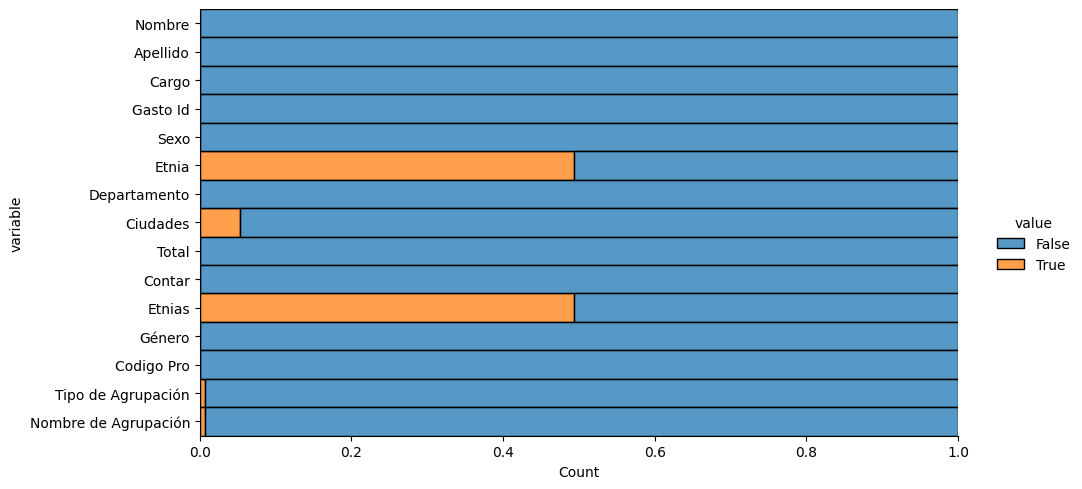

In [11]:
(
    gastos_df.isnull()
    .melt()
    .pipe(
        lambda df: (
            sns.displot(data=df, y="variable", hue="value", multiple="fill", aspect=2)
        )
    )
)

## Visualizacion de valores nulos


<Axes: >

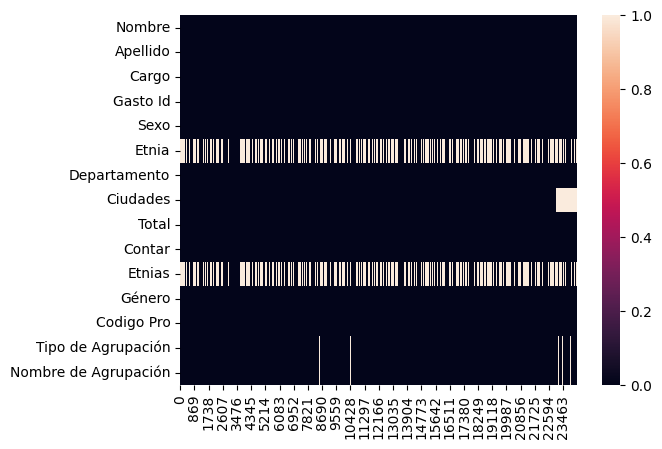

In [12]:
(
    gastos_df.isnull()
    .transpose()
    .pipe(
        lambda data: (
            sns.heatmap(
                data,
            )
        )
    )
)

# Conteo y proporciones

## Que estadisticos describen el conjunto de datos?


In [13]:
gastos_df.describe(include="all")

,Nombre,Apellido,Cargo,Gasto Id,Sexo,Etnia,Departamento,Ciudades,Total,Contar,Etnias,Género,Codigo Pro,Tipo de Agrupación,Nombre de Agrupación
count,24308,24308,24308,24308.000000,24306,12321.00000,24308,23005,2.430800e+04,24308.000000,12321,24306,24308,24125,24125
unique,5955,5704,2,NaN,2,NaN,33,1019,NaN,NaN,5,2,11,3,1838
top,JUAN CARLOS SARMIENTO SARMIENTO,LONDOÑO GARCIA,Alcaldia_fun,NaN,M,NaN,Cundinamarca,Granada,NaN,NaN,Ninguna de las anteriores,Masculino,207 - Gastos judiciales y de rendición de cuentas,Agrupacion Politica,PARTIDO CONSERVADOR COLOMBIANO
freq,12,22,23039,NaN,20167,NaN,2909,116,NaN,NaN,11416,20167,4566,14245,1262
mean,NaN,NaN,NaN,205.206311,NaN,4.75489,NaN,NaN,2.014093e+07,5.478772,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2.807494,NaN,0.88502,NaN,NaN,1.726824e+08,12.598493,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,201.000000,NaN,1.00000,NaN,NaN,0.000000e+00,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,203.000000,NaN,5.00000,NaN,NaN,1.200000e+06,1.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,205.000000,NaN,5.00000,NaN,NaN,4.600000e+06,2.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,207.000000,NaN,5.00000,NaN,NaN,1.407650e+07,5.000000,NaN,NaN,NaN,NaN,NaN


### Solo numericas


In [14]:
gastos_df.describe()

,Gasto Id,Etnia,Total,Contar
count,24308.000000,12321.00000,2.430800e+04,24308.000000
mean,205.206311,4.75489,2.014093e+07,5.478772
std,2.807494,0.88502,1.726824e+08,12.598493
min,201.000000,1.00000,0.000000e+00,1.000000
25%,203.000000,5.00000,1.200000e+06,1.000000
50%,205.000000,5.00000,4.600000e+06,2.000000
75%,207.000000,5.00000,1.407650e+07,5.000000
max,211.000000,5.00000,2.136100e+10,267.000000


### Solo categoricas -1


In [15]:
gastos_df.describe(include=object)

,Nombre,Apellido,Cargo,Sexo,Departamento,Ciudades,Etnias,Género,Codigo Pro,Tipo de Agrupación,Nombre de Agrupación
count,24308,24308,24308,24306,24308,23005,12321,24306,24308,24125,24125
unique,5955,5704,2,2,33,1019,5,2,11,3,1838
top,JUAN CARLOS SARMIENTO SARMIENTO,LONDOÑO GARCIA,Alcaldia_fun,M,Cundinamarca,Granada,Ninguna de las anteriores,Masculino,207 - Gastos judiciales y de rendición de cuentas,Agrupacion Politica,PARTIDO CONSERVADOR COLOMBIANO
freq,12,22,23039,20167,2909,116,11416,20167,4566,14245,1262


### Columnas categoricas


c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


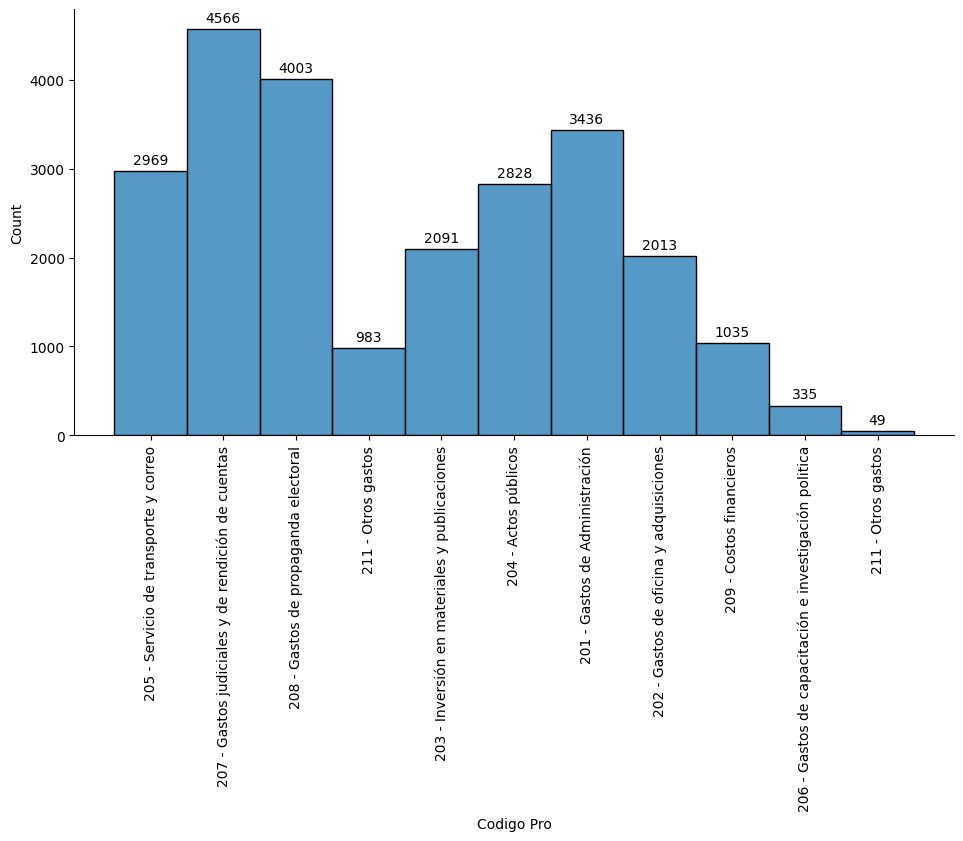

In [16]:
sns.displot(data=gastos_df, x="Codigo Pro", aspect=2)
plt.xticks(rotation=90)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


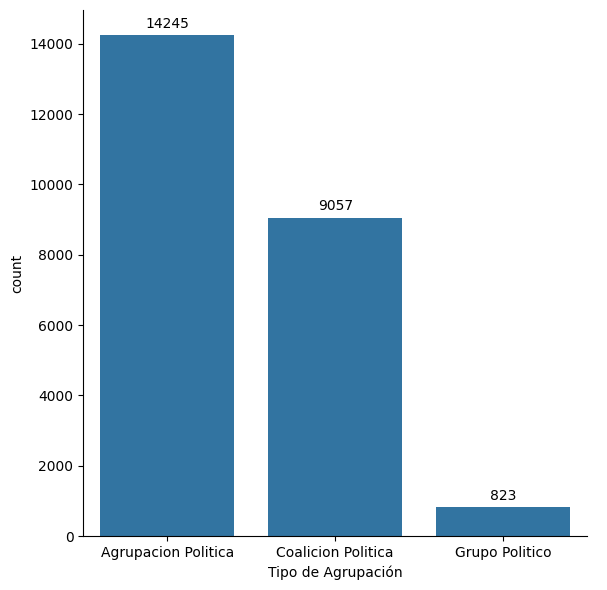

In [17]:
sns.catplot(
    x="Tipo de Agrupación",
    # col="Cargo",
    kind="count",
    height=6,
    aspect=1,
    data=gastos_df,
)


autoLabel()


plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


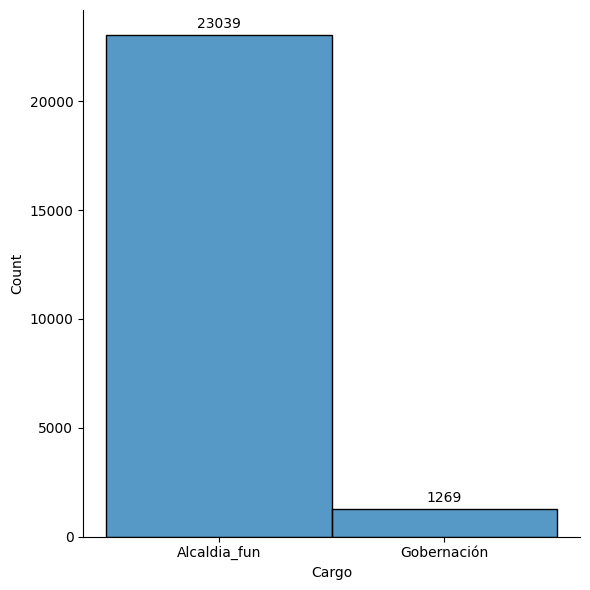

In [18]:
sns.displot(data=gastos_df, x="Cargo", height=6, aspect=1)
autoLabel()
plt.show()

## Normalizar datos de la columna Codigo Pro


In [19]:
gastos_df["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica',
       '211 -\xa0Otros\xa0gastos'], dtype=object)

In [20]:
def normalizeCodigoPro(fila):
    codigo = fila["Codigo Pro"]
    if isinstance(codigo, str):
        if codigo.startswith("211"):
            return codigo.replace("\xa0", " ")
        else:
            return codigo
    else:
        return codigo


gastos_df["Codigo Pro"] = gastos_df.apply(normalizeCodigoPro, axis=1)
gastos_df["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica'],
      dtype=object)

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_32732\1987836465.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


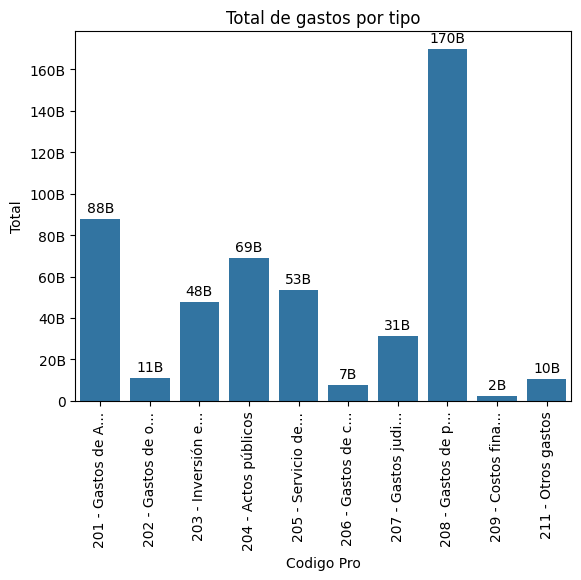

In [22]:
sns.barplot(
    x="Codigo Pro",
    y="Total",
    data=gastos_df.groupby("Codigo Pro")["Total"].sum().reset_index(),
)

def truncate_label(label, length=20):
    if len(label) > length:
        return label[: length - 3] + "..."
    else:
        return label


format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]
plt.title("Total de gastos por tipo")
plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)

plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_32732\1892799450.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


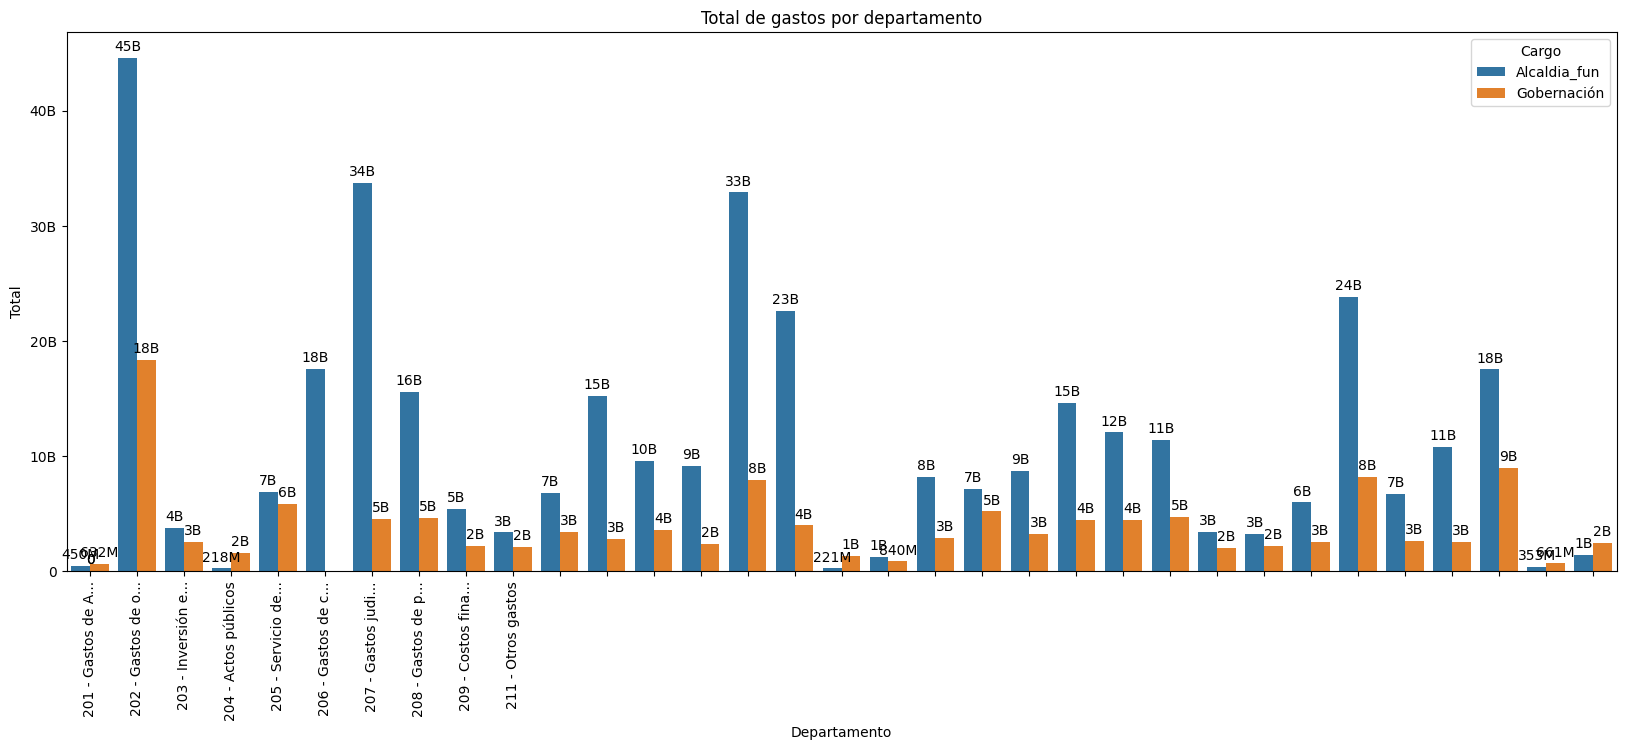

In [23]:
# sns.displot(x="Departamento", y="Total",kind='kde',height=8, aspect=1, data=gastos_df)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="Departamento",
    y="Total",
    hue="Cargo",
    # dodge=False,
    data=gastos_df.groupby(["Departamento", "Cargo"])["Total"].sum().reset_index(),
    # aspect=2
)


plt.title("Total de gastos por departamento")
plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()

plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


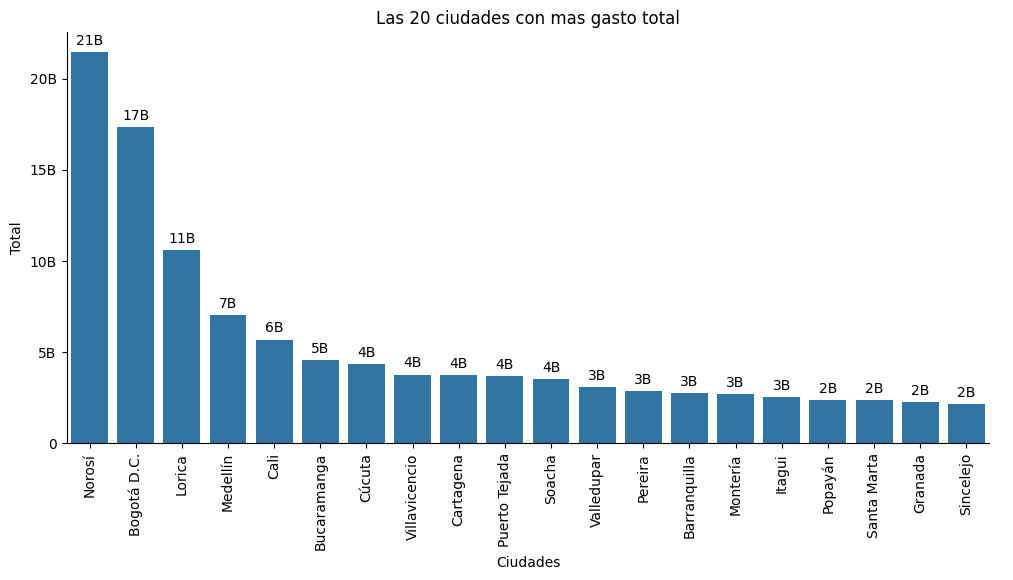

In [24]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = gastos_df.groupby("Ciudades")["Total"].sum().reset_index()

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")

# Luego, puedes usar seaborn para trazar un catplot
sns.catplot(
    x="Ciudades",
    y="Total",
    # hue="Tipo de Agrupación",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title("Las 20 ciudades con mas gasto total")

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

In [25]:
len(gastos_df["Nombre de Agrupación"].unique())

1839

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\SergioxD\AppData\Local\Temp\ipykernel_32732\2291533764.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


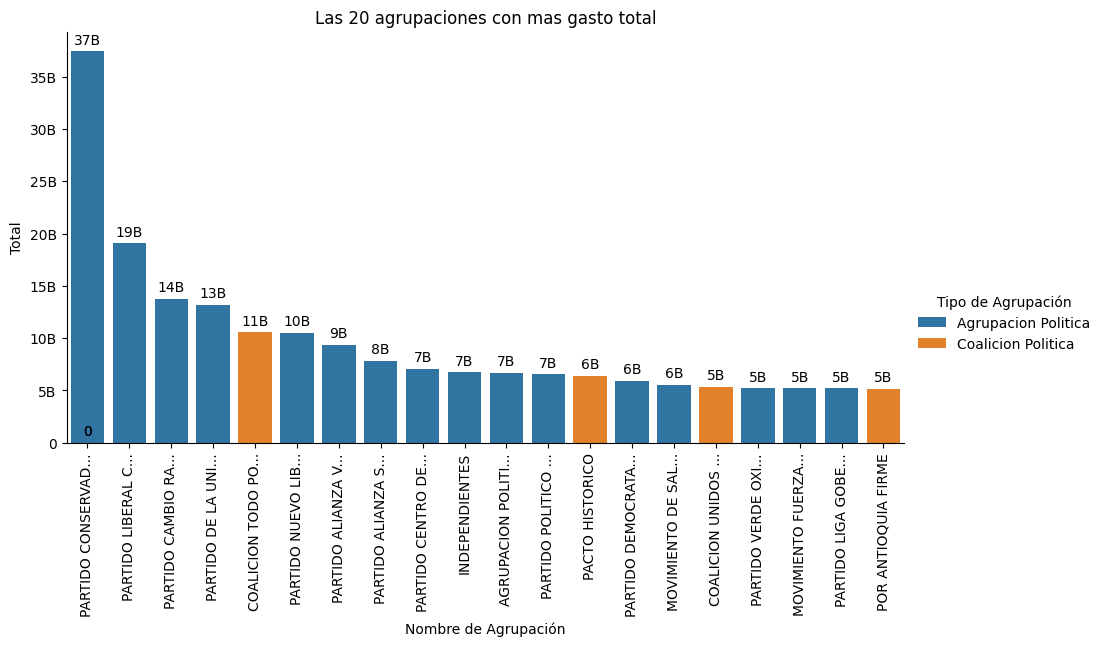

In [26]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = (
    gastos_df.groupby(["Nombre de Agrupación", "Tipo de Agrupación"])["Total"]
    .sum()
    .reset_index()
)

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")

# Luego, puedes usar seaborn para trazar un catplot
sns.catplot(
    x="Nombre de Agrupación",
    y="Total",
    hue="Tipo de Agrupación",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title("Las 20 agrupaciones con mas gasto total")
format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]
plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


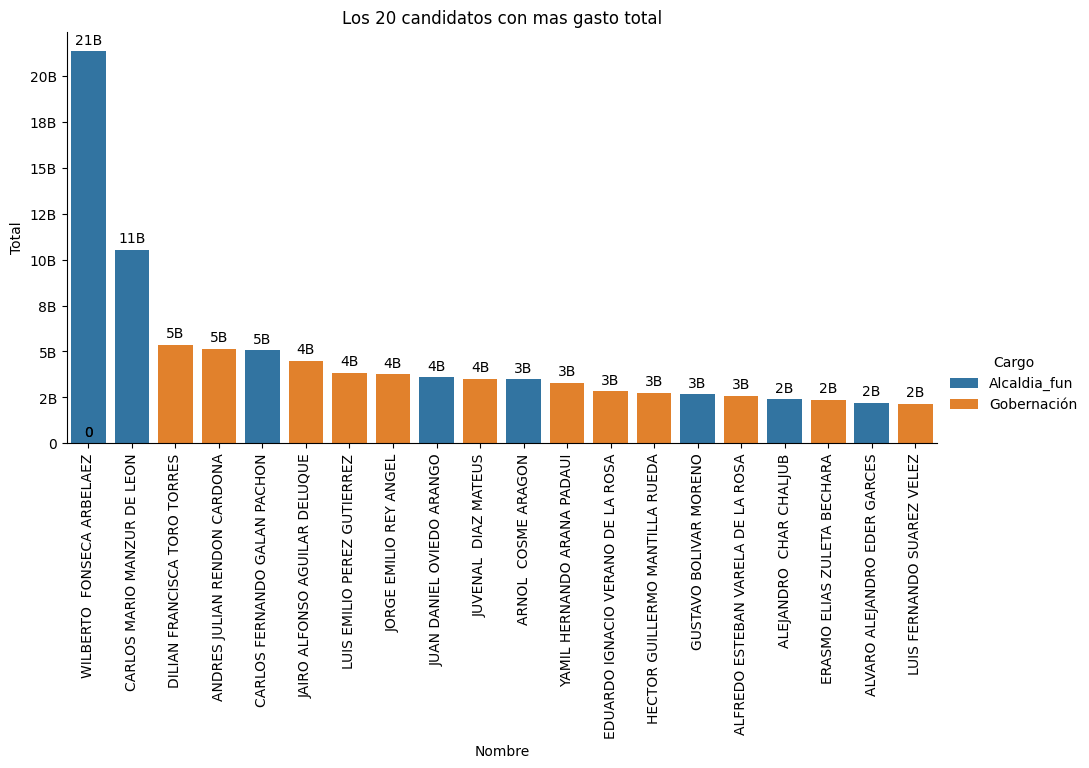

In [27]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = gastos_df.groupby(["Nombre", "Cargo"])["Total"].sum().reset_index()

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")

# Luego, puedes usar seaborn para trazar un catplot
sns.catplot(x="Nombre", y="Total", hue="Cargo", kind="bar", data=df_top_10, aspect=2)
plt.title("Los 20 candidatos con mas gasto total")

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

In [28]:
gastos_df["Departamento"].unique()

array(['Antioquia', 'Bolívar', 'Nariño', 'Atlántico', 'Putumayo',
       'Caldas', 'Magdalena', 'Santander', 'Córdoba', 'Huila', 'Tolima',
       'Meta', 'Chocó', 'Valle del Cauca', 'Cundinamarca', 'Boyacá',
       'Cesar', 'Sucre', 'Cauca', 'Norte de Santander', 'Vichada',
       'Casanare', 'La Guajira', 'Risaralda',
       'Archipiélago de San Andrés, Providencia y Santa Catalina',
       'Quindío', 'Caquetá', 'Arauca', 'Amazonas', 'Guainía',
       'Bogotá D.C.', 'Vaupés', 'Guaviare'], dtype=object)

In [29]:
gastos_df["Cargo"].unique()

array(['Alcaldia_fun', 'Gobernación'], dtype=object)

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


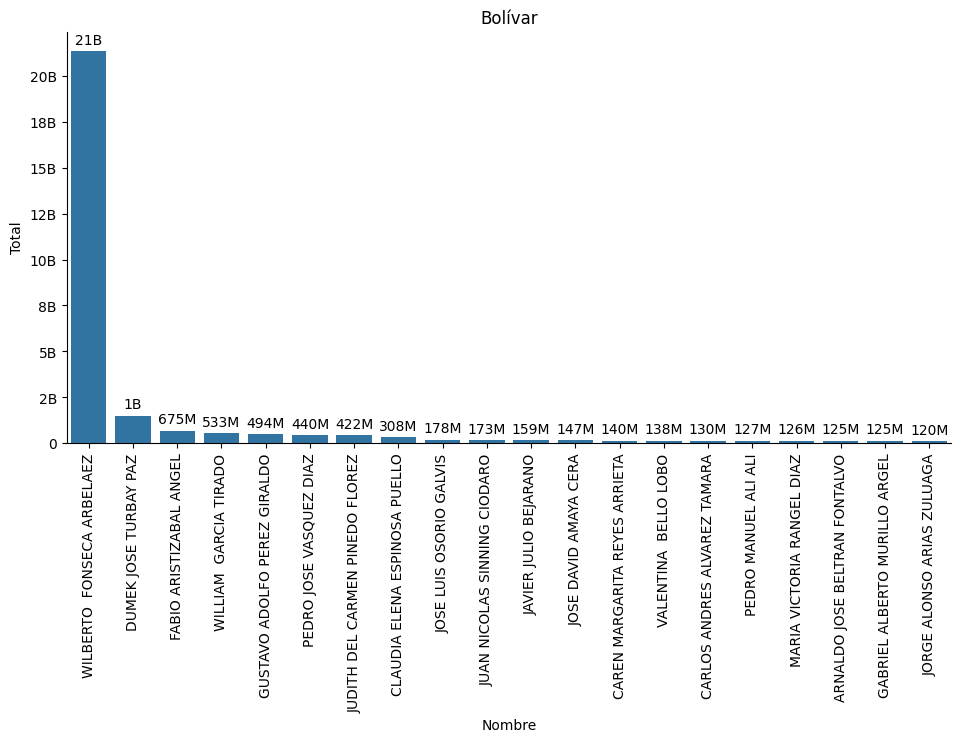

In [30]:
# Luego, puedes usar seaborn para trazar un catplot
departamento = "Bolívar"
cargo = "Alcaldia_fun"
gastos_departamento_df = gastos_df[
    (gastos_df["Departamento"] == departamento) & (gastos_df["Cargo"] == cargo)
]

# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = (
    gastos_departamento_df.groupby(["Nombre", "Cargo"])["Total"].sum().reset_index()
)

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")


sns.catplot(
    x="Nombre",
    y="Total",
    # hue="Cargo",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title(departamento)

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\SergioxD\AppData\Local\Temp\ipykernel_32732\2868225857.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


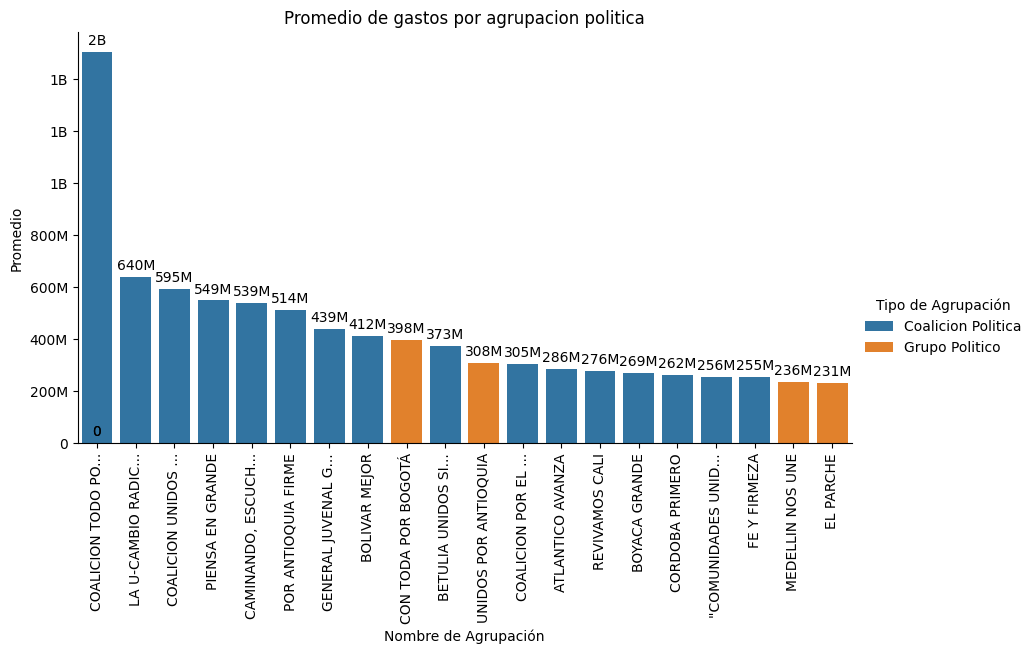

In [31]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = gastos_df.groupby(["Nombre de Agrupación", "Tipo de Agrupación"])


agg_data = grouoped_data.agg(Promedio=pd.NamedAgg(column="Total", aggfunc="mean"))
# Filtrar los primeros 10 resultados
df_top_10 = agg_data.nlargest(20, "Promedio")
sns.catplot(
    x="Nombre de Agrupación",
    y="Promedio",
    hue="Tipo de Agrupación",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title("Promedio de gastos por agrupacion politica")
format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]
plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\SergioxD\AppData\Local\Temp\ipykernel_32732\1394198019.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


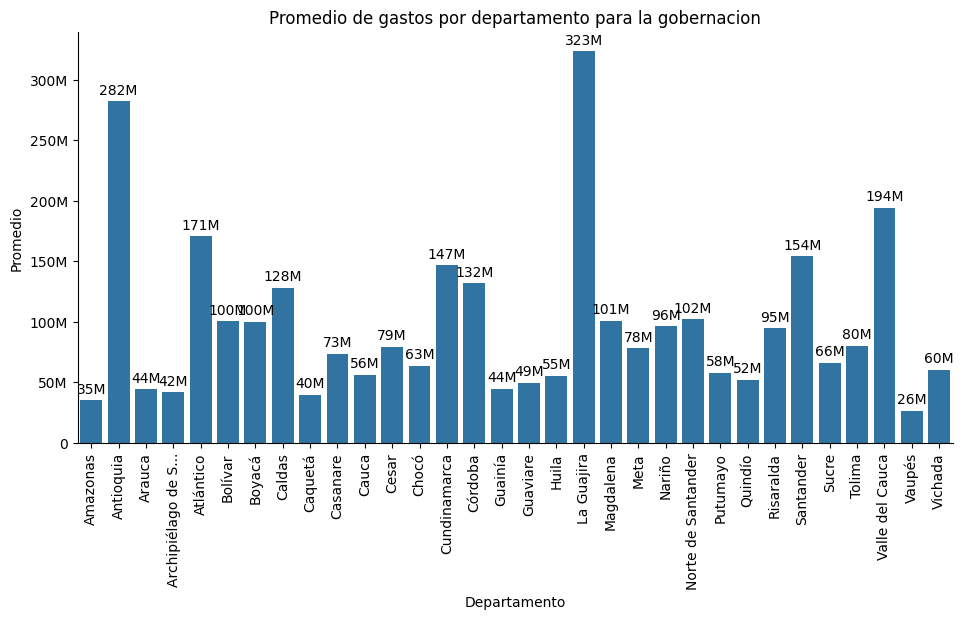

In [32]:
# Calcular la suma del Total por departamento

cargo = "Gobernación"
gastos_departamento_df = gastos_df[(gastos_df["Cargo"] == cargo)]
grouped_data = gastos_departamento_df.groupby(["Departamento"])

agg_data = grouped_data.agg(Promedio=pd.NamedAgg(column="Total", aggfunc="mean"))
# Filtrar los primeros 10 resultados
# df_top_10 = agg_data.nlargest(20, "Promedio")
sns.catplot(
    x="Departamento",
    y="Promedio",
    # hue="Cargo",
    kind="bar",
    data=agg_data,
    aspect=2,
)
plt.title("Promedio de gastos por departamento para la gobernacion")

plt.xticks(rotation=90)
format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\SergioxD\AppData\Local\Temp\ipykernel_32732\1486296068.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


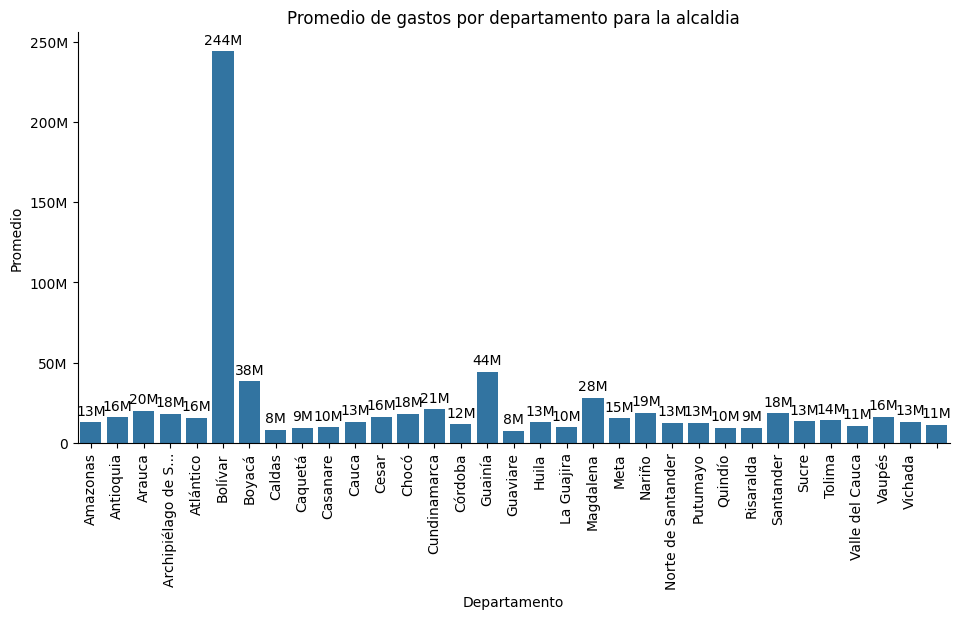

In [33]:
# Calcular la suma del Total por departamento

cargo = "Alcaldia_fun"
gastos_departamento_df = gastos_df[(gastos_df["Cargo"] == cargo)]
grouped_data = gastos_departamento_df.groupby(["Departamento"])

agg_data = grouped_data.agg(Promedio=pd.NamedAgg(column="Total", aggfunc="mean"))
# Filtrar los primeros 10 resultados
# df_top_10 = agg_data.nlargest(20, "Promedio")
sns.catplot(
    x="Departamento",
    y="Promedio",
    # hue="Cargo",
    kind="bar",
    data=agg_data,
    aspect=2,
)
plt.title("Promedio de gastos por departamento para la alcaldia")

plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


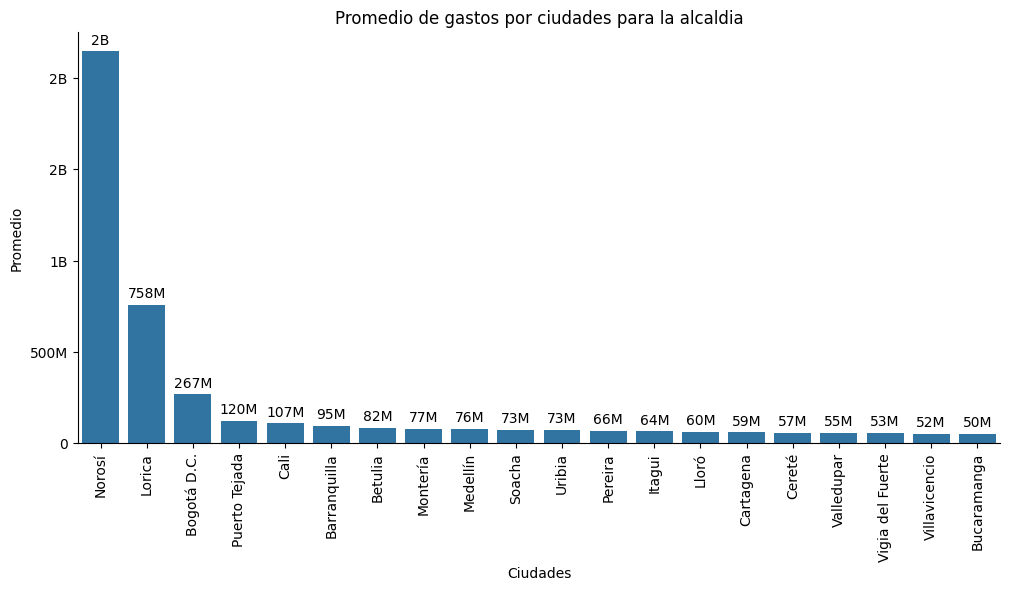

In [34]:
# Calcular la suma del Total por departamento

cargo = "Alcaldia_fun"
gastos_departamento_df = gastos_df[(gastos_df["Cargo"] == cargo)]
grouped_data = gastos_departamento_df.groupby(["Ciudades"])

agg_data = grouped_data.agg(Promedio=pd.NamedAgg(column="Total", aggfunc="mean"))
# Filtrar los primeros 10 resultados
df_top_10 = agg_data.nlargest(20, "Promedio")
sns.catplot(
    x="Ciudades",
    y="Promedio",
    # hue="Cargo",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title("Promedio de gastos por ciudades para la alcaldia")

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

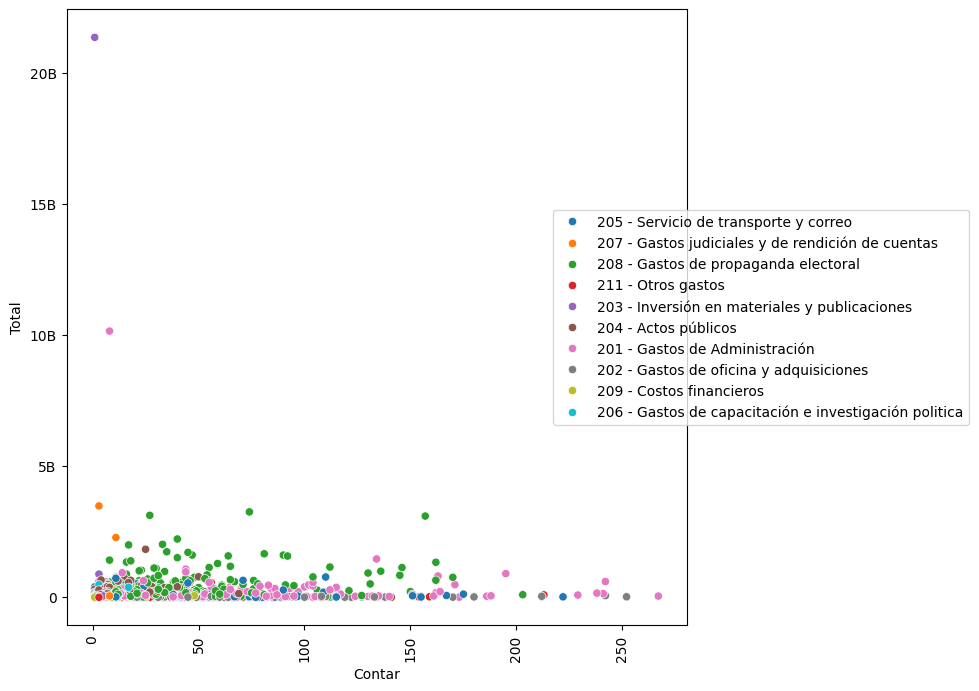

In [35]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=gastos_df, x="Contar", y="Total", hue="Codigo Pro")
plt.legend(loc="center", bbox_to_anchor=(1.12, 0.5))
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


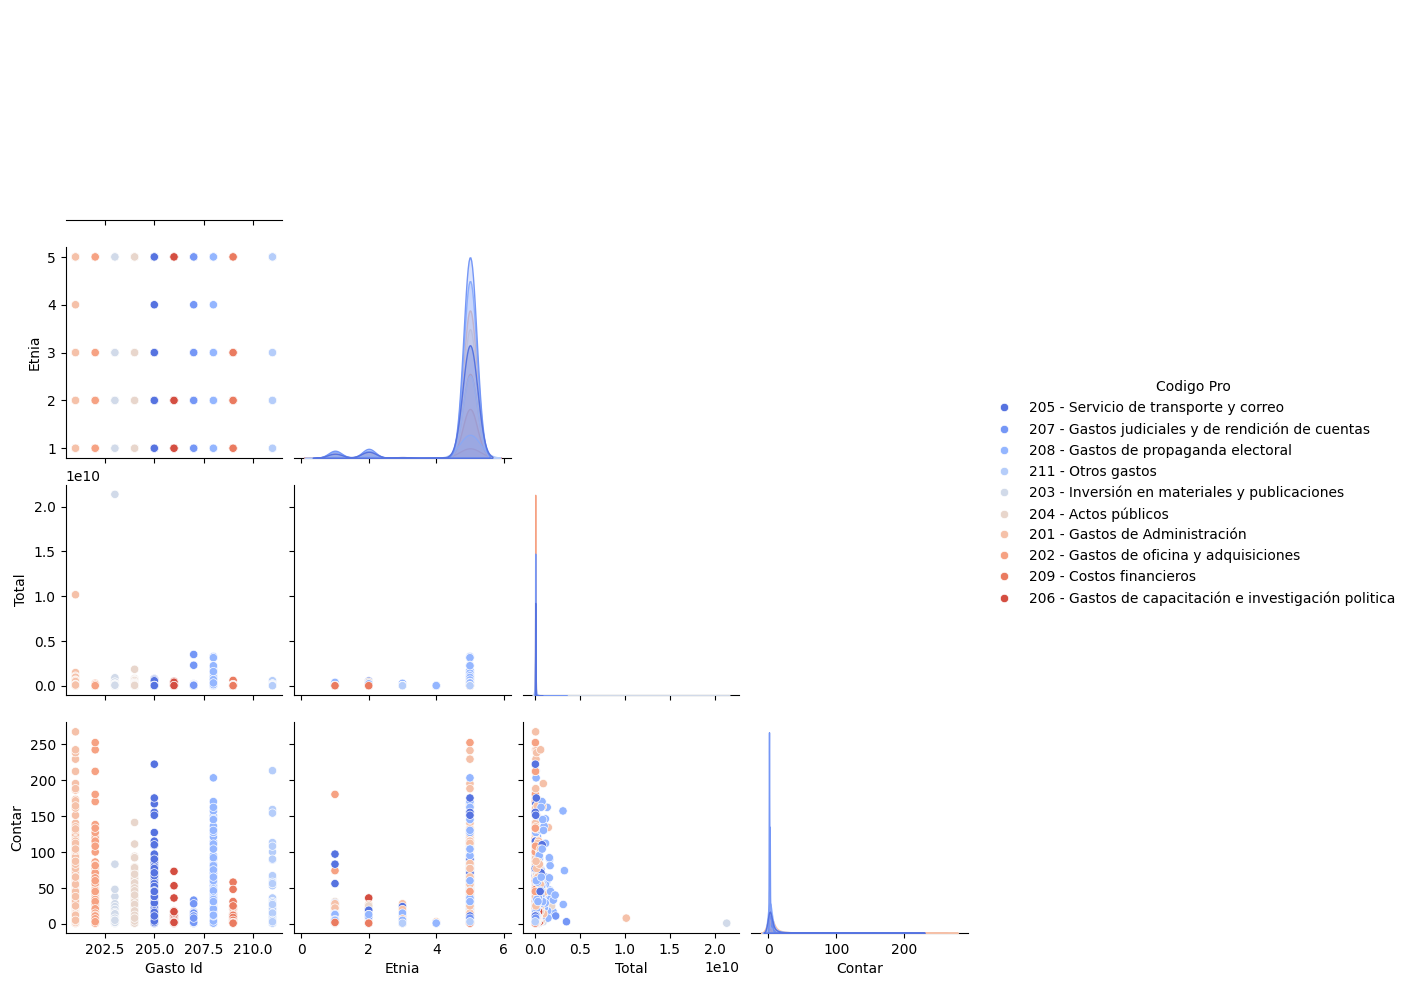

In [36]:
sns.pairplot(
    data=gastos_df, hue="Codigo Pro", palette="coolwarm", corner=True, kind="scatter"
)
plt.show()

In [37]:
# shapefile_path = (
#     "data/Servicios_PBAblicos_-_Municipios/Servicios_P%C3%BAblicos_-_Municipios"
# )


# gdf = gpd.read_file('data/Servicios_PBAblicos_-_Municipios/Servicios_P%C3%BAblicos_-_Municipios.shp')


# fig, ax = plt.subplots(figsize=(10, 10))

# # Dibujar el mapa base de Colombia
# gdf.plot(ax=ax, color='lightgray', edgecolor='black')


# def formatear_texto(texto):
#     return texto.lower().capitalize()

# # Aplicar la función a la columna 'DEPTO' del GeoDataFrame
# gdf["DEPTO"] = gdf["DEPTO"].apply(formatear_texto)

# # # Verificar los nombres de los atributos
# # print(gdf.columns)
# # # Verificar la información general del GeoDataFrame
# # print(gdf.info())

# # Fusionar el DataFrame con los datos de gasto en el GeoDataFrame
# gdf_con_gasto = gdf.merge(gastos_df, left_on='DEPTO', right_on='Departamento')

# # Crear la figura y los ejes
# fig, ax = plt.subplots(figsize=(10, 10))

# # Dibujar el mapa base de Colombia
# gdf_con_gasto.plot(ax=ax, color='lightgray', edgecolor='black')

# # Superponer los datos de gasto en el mapa
# gdf_con_gasto.plot(ax=ax, column='Total', legend=True)

# # Etiquetar los departamentos con el nombre y el gasto
# for index, row in gdf_con_gasto.iterrows():
#     ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['DEPTO']}: ${row['Total']}",
#             fontsize=8, ha='center')

# # Ajustar el tamaño de la figura
# plt.tight_layout()

# # Mostrar el mapa
# plt.show()